# Contrastive Loss

In [30]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
# from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from beeid.utils import sensitivity_map

from code.models import simple_cnnv2, ContrastiveLearning
from code.data_utils import load_tf_pair_dataset, load_tf_dataset
from code.viz import show_sensitivity_maps
from code.evaluation import cmc_evaluation, plot_cmc
from code.evaluation import get_interactive_plot_query_gallery

ImportError: cannot import name 'full_evaluation' from 'code.evaluation' (/home/jchan/beeid/notebooks/cmc_experiments/code/evaluation.py)

### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [31]:
pair_train_df = pd.read_csv("data/untagged_train_pairs.csv")
pair_valid_df = pd.read_csv("data/untagged_valid_pairs.csv")
valid_df = pd.read_csv("data/valid.csv")
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Tensorflow Dataset

In [3]:
import tensorflow as tf
from beeid.augmentation import random_erasing, color_jitter, color_drop
import tensorflow_addons as tfa
import numpy as np

@tf.function 
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def apply_rescale(dataset, rescale_factor=1, image_size=(512, 512)):
    target_size = [image_size[0]//rescale_factor, image_size[1]//rescale_factor]
    func = lambda x: tf.image.resize(x, target_size)
    dataset = dataset.map(func, num_parallel_calls=10)
    return dataset

def get_abdomen(image):
    return image[272:496, 144:368,:]

def load_tf_pair_dataset(df, rescale_factor=1, augmentation=False, censored=True, label_column="track_tag_id"):
    
    filenames_x, filenames_y, labels = df.filename_x.values, df.filename_y.values, df[label_column].values
        
    filenames_x = tf.data.Dataset.from_tensor_slices(filenames_x)
    filenames_y = tf.data.Dataset.from_tensor_slices(filenames_y)
    
    labels = tf.data.Dataset.from_tensor_slices(labels)
    
    images_x = filenames_x.map(load_image, num_parallel_calls=10)
    images_x = images_x.map(get_abdomen, num_parallel_calls=10)
    images_x = apply_rescale(images_x, rescale_factor=rescale_factor, image_size=(224, 224))
    
    images_y = filenames_y.map(load_image, num_parallel_calls=10)
    images_y = images_y.map(get_abdomen, num_parallel_calls=10)
    images_y = apply_rescale(images_y, rescale_factor=rescale_factor, image_size=(224, 224))
    
    if augmentation:
        images_x = images_x.map(gaussian_blur, num_parallel_calls=10)
        images_x = images_x.map(color_jitter, num_parallel_calls=10)
        images_x = images_x.map(color_drop, num_parallel_calls=10)
        images_x = images_x.map(random_erasing, num_parallel_calls=10)
        
        images_y = images_y.map(gaussian_blur, num_parallel_calls=10)
        images_y = images_y.map(color_jitter, num_parallel_calls=10)
        images_y = images_y.map(color_drop, num_parallel_calls=10)
        images_y = images_y.map(random_erasing, num_parallel_calls=10)
        
    dataset = tf.data.Dataset.zip((images_x, images_y, labels))
    return dataset

@tf.function 
def gaussian_blur(image, p=0.5, sigma_min=0.5, sigma_max=1.75):
    prob = np.random.random_sample()
    if prob < p:
        sigma = (sigma_max - sigma_min) * np.random.random_sample() + sigma_min
        image = tfa.image.gaussian_filter2d(image, (5, 5), sigma)
    return image

In [4]:
train_pair_dataset = load_tf_pair_dataset(pair_train_df, rescale_factor=4, augmentation=True, label_column="label_x")
train_pair_dataset = train_pair_dataset.batch(64)

In [5]:
valid_pair_dataset = load_tf_pair_dataset(pair_valid_df, rescale_factor=4, label_column="label_x").batch(20)

In [6]:
data = train_pair_dataset
gen = iter(data)


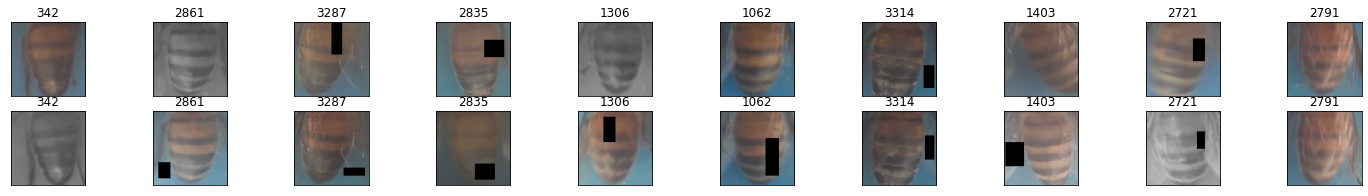

In [16]:
sample_batch = next(gen)

EXAMPLES=2

fig, ax = plt.subplots(EXAMPLES, 10, figsize=(25, 3))

for j in range(10):
    ax[0, j].imshow(sample_batch[0][j])
    ax[1, j].imshow(sample_batch[1][j])
    ax[0, j].set_title("{}".format(sample_batch[2][j].numpy()))
    ax[1, j].set_title("{}".format(sample_batch[2][j].numpy()))
    ax[0, j].set_xticks([])
    ax[0, j].set_yticks([])
    ax[1, j].set_xticks([])
    ax[1, j].set_yticks([])

### Model

In [17]:
backbone = simple_cnnv2(input_shape=(56, 56, 3), conv_blocks=3, latent_dim=128)
model = ContrastiveLearning(backbone, temperature=0.1)

In [18]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

In [ ]:
# Train the network
EPOCHS=10
PATIENCE=3


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(train_pair_dataset, validation_data=valid_pair_dataset, epochs=EPOCHS, callbacks=[earlystop])

Epoch 1/10
28374/28374 [==============================] - 2771s 98ms/step - loss: 0.7364 - val_loss: 1.6150
Epoch 2/10
11400/28374 [===========>..................] - ETA: 26:49 - loss: 0.6117

In [ ]:
model.save("models/pretraining_contrastive_loss_t0-1.tf")

<AxesSubplot:>

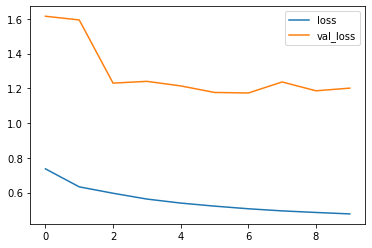

In [28]:
pd.DataFrame(history.history).plot()

In [25]:
valid_dataset = load_tf_dataset(valid_df, rescale_factor=4)

### Checking Training

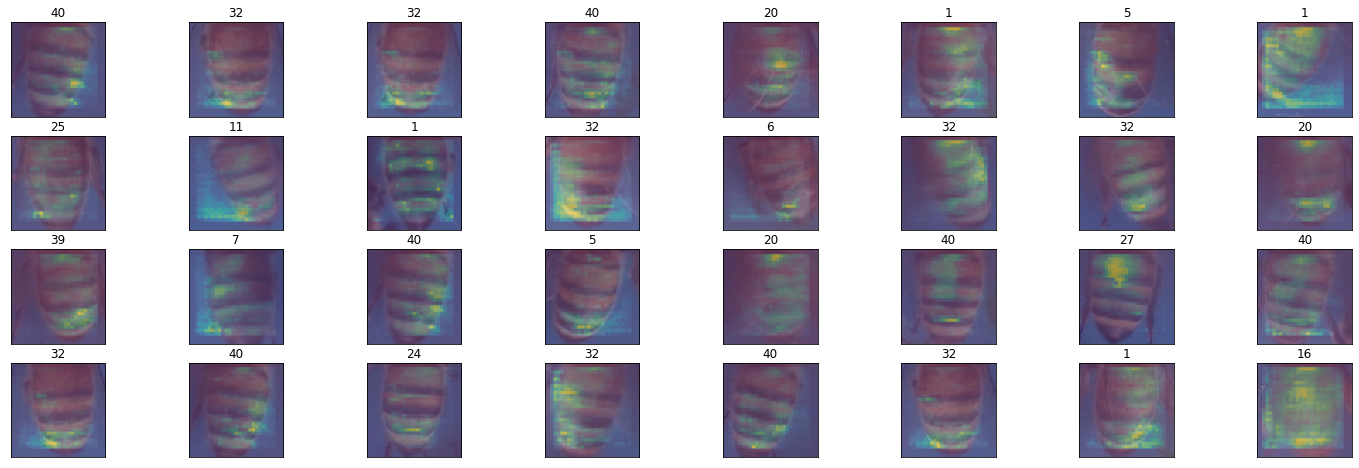

In [26]:
show_sensitivity_maps(model, valid_dataset)

#### Save model

In [ ]:
# model.save("models/contrastive_loss_T1.tf")

## Evaluation

In [32]:
ITERATIONS=100
GALLERY_SIZE=10

### Evaluation on ids shared with the training set (validation set)

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


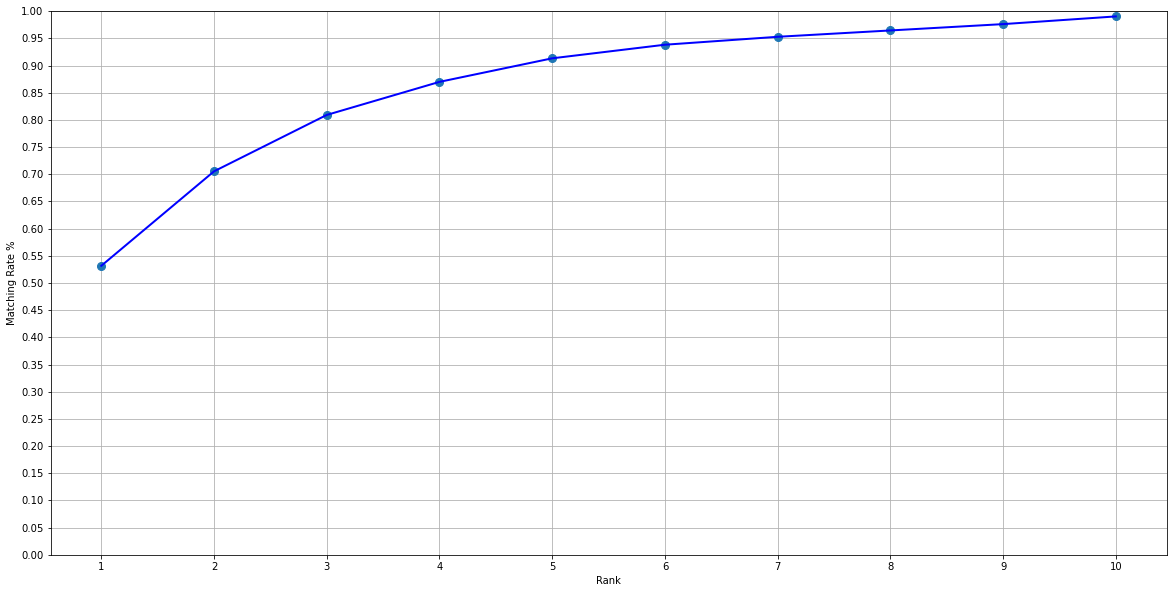

In [33]:
train_ids = train_df.track_tag_id.unique()

valid_with_shared_ids = valid_df[valid_df.track_tag_id.isin(train_ids)]

valid_with_shared_ids_ranks_means = cmc_evaluation(model, valid_with_shared_ids, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_with_shared_ids_ranks_means)

### Evaluation on ids shared with the whole validation set

100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


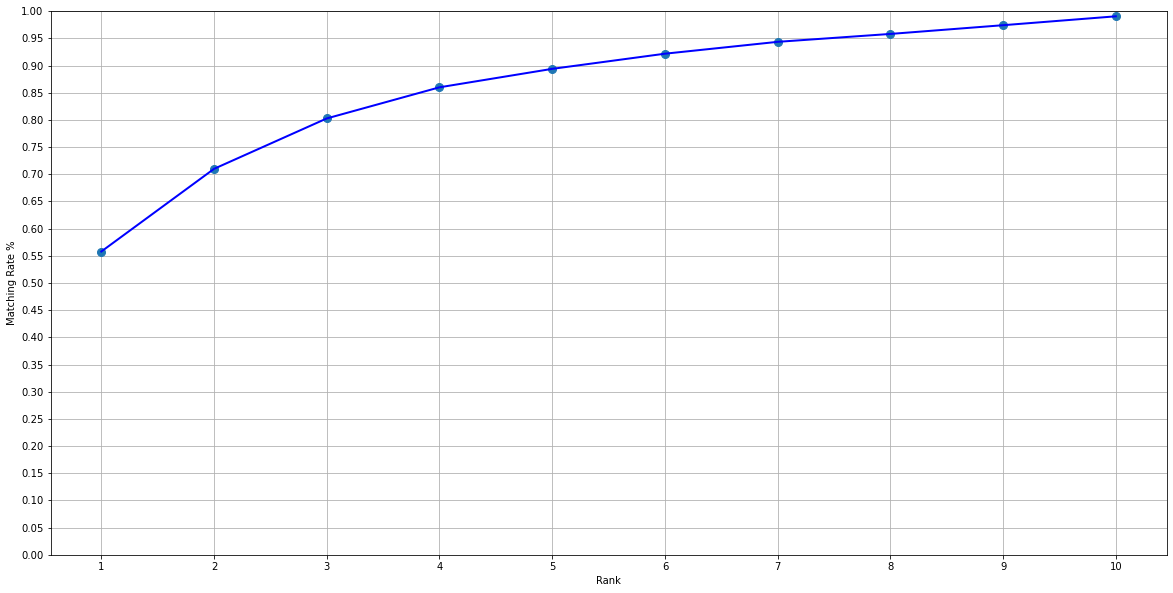

In [34]:
valid_ranks_means = cmc_evaluation(model, valid_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_ranks_means)

### Evaluation on test set

100%|██████████| 100/100 [13:03<00:00,  7.84s/it]


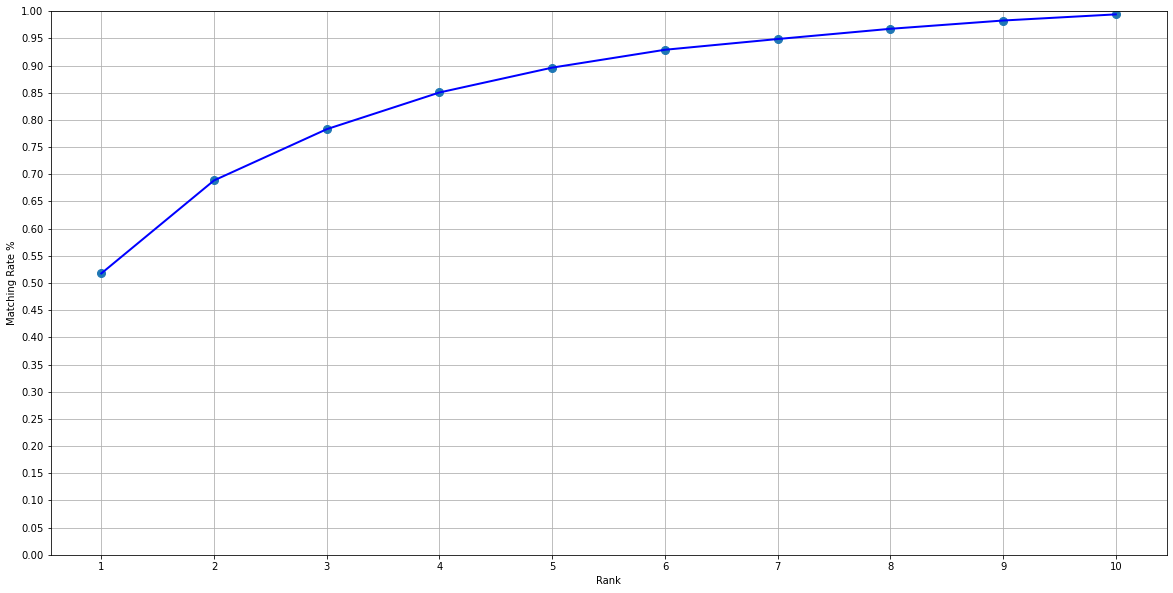

In [35]:
test_ranks_means = cmc_evaluation(model, test_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_ranks_means)

In [36]:
train_ids = train_df.track_tag_id.unique()
test_ids = test_df.track_tag_id.unique()


intersection = set(train_ids) & set(test_ids)

print("Test set has {} Ids.".format(len(test_ids)))
print("Intersection of train and test set {}".format(len(intersection)))

Test set has 126 Ids.
Intersection of train and test set 29


100%|██████████| 100/100 [08:18<00:00,  4.98s/it]


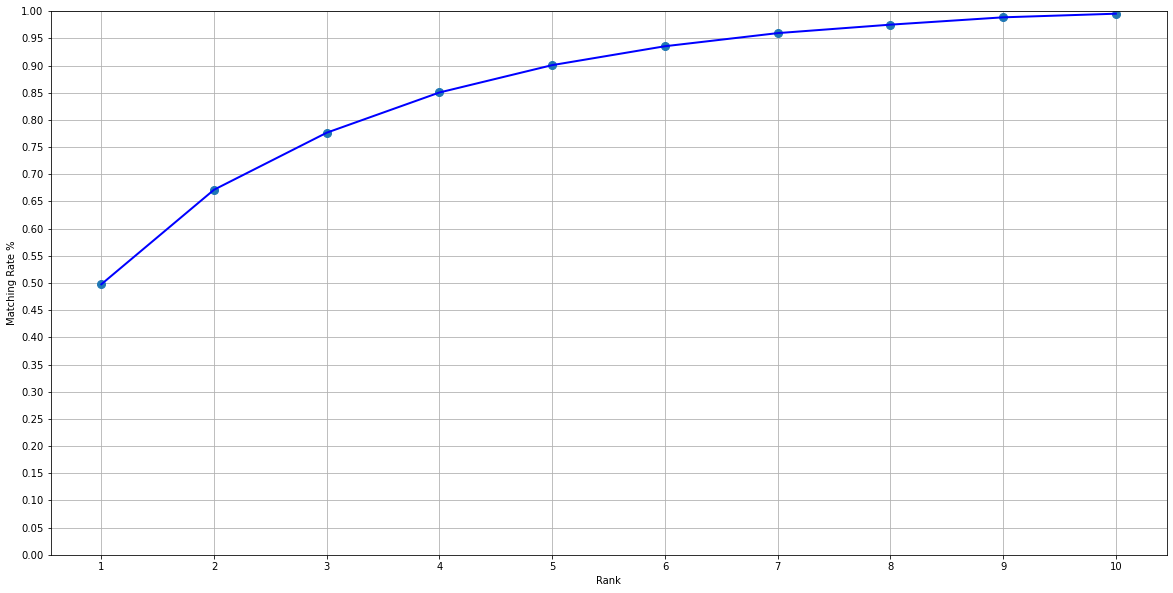

In [37]:
test_disjoint_train = test_df[~test_df.track_tag_id.isin(train_ids)]

test_disjoint_train_ranks_means = cmc_evaluation(model, test_disjoint_train, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_disjoint_train_ranks_means)

#### Saving results

In [38]:
metric_dict = dict()

metric_dict["valid_cmc_only_train_ids"] = valid_with_shared_ids_ranks_means 
metric_dict["valid_cmc"] = valid_ranks_means
metric_dict["test_cmc"] = test_ranks_means
metric_dict["test_cmc_no_ids_overlap"] = test_disjoint_train_ranks_means

metric_df = pd.DataFrame(metric_dict)
metric_df.to_csv("results/pretraining_contrastive_loss_t0-1.csv")

In [39]:
metric_df

,valid_cmc_only_train_ids,valid_cmc,test_cmc,test_cmc_no_ids_overlap
0,0.531667,0.557879,0.517619,0.497619
1,0.705417,0.710000,0.688690,0.671587
2,0.809167,0.802727,0.782976,0.776508
3,0.870000,0.860000,0.850476,0.850476
4,0.913333,0.893939,0.896190,0.900794
5,0.938333,0.921818,0.929048,0.935556
6,0.952917,0.943636,0.948810,0.959683
7,0.964583,0.958182,0.967619,0.975238
8,0.976250,0.974242,0.982857,0.988730
9,0.990417,0.990606,0.994167,0.995397


#### Interactive Query Plotting

In [17]:
get_interactive_plot_query_gallery(model, valid_df)

interactive(children=(IntSlider(value=17, description='query_id', max=34), Checkbox(value=False, description='…